In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    distance = np.random.uniform(low=1, high=3, size=len(G.edges))
    for ((a, b), d) in zip(G.edges, distance):
        G.edges[a, b]["distance"] = d
        G.edges[a, b]["delay"] = f"uniform {d * 0.5} {d * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / d
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = seed
    with subprocess.Popen(
        ["dune", "exec", "graphml_runner"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.145292,2.219407,0.450571,1.825983,0.547650
1,0.306829,3.631759,0.275349,2.587697,0.386444
2,0.174262,2.735377,0.365580,2.646335,0.377881
3,0.216029,3.257069,0.307025,2.803346,0.356717
4,0.076233,4.252768,0.235141,3.893994,0.256806
5,0.080964,2.560951,0.390480,2.166403,0.461595
6,0.000391,3.022283,0.330876,2.975119,0.336121


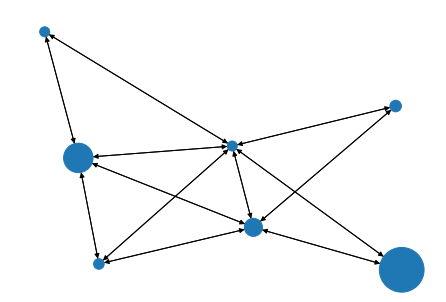

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

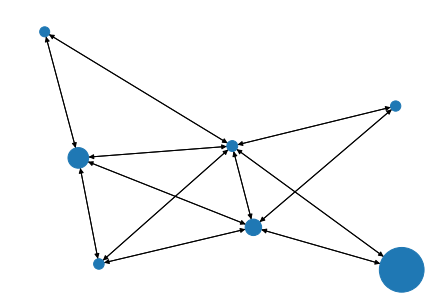

In [5]:
draw(G, size="reward", layout=layout)

In [6]:
runs = []
for i in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in ["nakamoto", "ethereum", "tailstorm 8 constant", "tailstorm 8 discount"]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
            seed=i,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
0,351.0,295.000,0.763223,1.310233,0.451515,2.214765,0.368020,nakamoto,0.008968,0.007375,0.871289
1,37.0,12.000,0.279884,3.572913,0.267205,3.742447,0.023030,nakamoto,0.000365,0.000300,0.566362
2,261.0,202.000,0.642022,1.557578,0.370031,2.702473,0.252804,nakamoto,0.006141,0.005050,0.868519
3,96.0,41.000,0.396361,2.522954,0.290034,3.447872,0.092226,nakamoto,0.001246,0.001025,0.483216
4,2.0,1.000,0.404917,2.469641,0.391460,2.554541,0.003087,nakamoto,0.000030,0.000025,0.352051
...,...,...,...,...,...,...,...,...,...,...,...
2,447.0,365.375,0.779205,1.283359,0.399436,2.503528,0.426334,tailstorm 8 discount,0.011107,0.009134,0.931538
3,49.0,37.375,0.478450,2.090083,0.448830,2.228017,0.051700,tailstorm 8 discount,0.001136,0.000934,0.785786
4,96.0,61.875,0.389537,2.567148,0.331274,3.018653,0.103335,tailstorm 8 discount,0.001881,0.001547,0.650850
5,199.0,160.750,0.588690,1.698688,0.523707,1.909463,0.205754,tailstorm 8 discount,0.004887,0.004019,0.849210


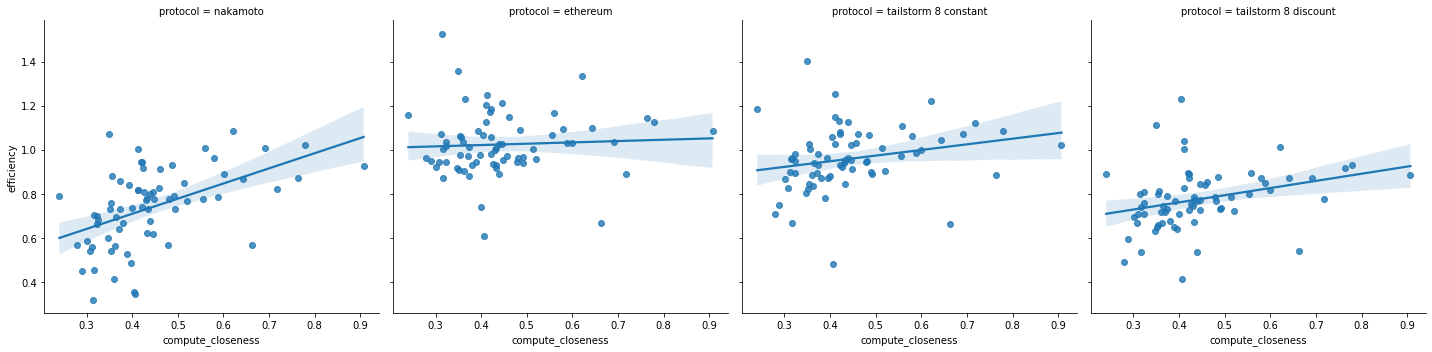

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")